In [1]:
from collections import namedtuple

Layout = namedtuple("Layout", ["functions", "basic_blocks", "instructions"])

In [2]:
import os
import os.path
import gzip
import json

def find_by_suffix(path, suffix):
    return os.path.join(path, [f for f in os.listdir(path) if f.endswith(suffix)][0])

def get_gt_layout(path):
    with open(find_by_suffix(path, ".gt.json.gz"), "rb") as f:
        doc = json.loads(gzip.decompress(f.read()))

    functions = set([])
    basic_blocks  = set([])
    instructions  = set([])
    for f in doc["module"].get("fuc", []):
        functions.add(int(f["va"]))
        for bb in f.get("bb", []):
            basic_blocks.add(int(bb["va"]))
            for insn in bb.get("instructions", []):
                instructions.add(int(insn["va"]))

    return Layout(functions, basic_blocks, instructions)

In [3]:
gt_layout = get_gt_layout("SoK-windows-testsuite/cl_m32_Od/gobmk/")
print(f"function count:    {len(gt_layout.functions)}")
print(f"basic block count: {len(gt_layout.basic_blocks)}")
print(f"instruction count: {len(gt_layout.instructions)}")

function count:    3290
basic block count: 40561
instruction count: 235510


In [4]:
import lancelot

def get_lancelot_workspace(path):
    try:
        with open(find_by_suffix(path, ".exe"), "rb") as f:
            return lancelot.from_bytes(f.read())
    except IndexError:
        pass
    
    with open(find_by_suffix(path, ".dll"), "rb") as f:
        return lancelot.from_bytes(f.read())
    
def get_lancelot_layout(path):
    ws = get_lancelot_workspace(path)
    
    functions = set([])
    basic_blocks  = set([])
    instructions  = set([])    
    for f in ws.get_functions():
        functions.add(f)
        try:
            cfg = ws.build_cfg(f)
        except:
            continue
        else:
            for bb in cfg.basic_blocks.values():
                basic_blocks.add(bb.address)
                
                va = bb.address
                while va < bb.address + bb.length:
                    try:
                        insn = ws.read_insn(va)
                    except ValueError:
                        break
                    instructions.add(va)
                    va += insn.length

    return Layout(functions, basic_blocks, instructions)

In [5]:
lancelot_layout = get_lancelot_layout("SoK-windows-testsuite/cl_m32_Od/gobmk/")
print(f"function count:    {len(lancelot_layout.functions)}")
print(f"basic block count: {len(lancelot_layout.basic_blocks)}")
print(f"instruction count: {len(lancelot_layout.instructions)}")

function count:    3368
basic block count: 39100
instruction count: 227768


In [17]:
def get_standard_layout(path, suffix):
    """
    the "standard layout" format is a text file with lines like:
    
        function: 0x140013638
        basic block: 0x140013638
        instruction: 0x140013638
        instruction: 0x14001363c
        
    see dump_ida_layout.py
    see dump_viv_layout.py
    """
    functions = set([])
    basic_blocks  = set([])
    instructions  = set([])  
    with open(find_by_suffix(path, suffix), "rb") as f:
        for line in gzip.decompress(f.read()).decode("utf-8").split("\n"):
            if not line: continue
            key, _, va = line.partition(": ")
            if not va: continue
            va = int(va.rstrip("L"), 0x10)
            if key == "function":
                functions.add(va)
            elif key == "basic block":
                basic_blocks.add(va)
            elif key == "instruction":
                instructions.add(va)
            else:
                raise RuntimeError("unexpected key: " + key)
                
    return Layout(functions, basic_blocks, instructions)
        
def get_viv_layout(path):
    return get_standard_layout(path, ".viv.txt.gz")

def get_ida_layout(path):
    """
    extract from IDA via cli like:
    
        rm log.txt
        /mnt/c/Program\ Files/IDA\ Pro\ 7.5/ida64.exe -P+ -A -S"C:/Users/user/dump_ida_layout.py" -Llog.txt SoK-windows-testsuite/cl_m32_Od/gobmk/gobmk.exe.i64
        cat log.txt | grep "^\(function\|basic block\|instruction\): " | gzip - > SoK-windows-testsuite/cl_m32_Od/gobmk/gobmk.exe.i64.txt.gz
    """
    return get_standard_layout(path, ".i64.txt.gz")

def get_db_layout(path):
    return get_standard_layout(path, ".db.txt.gz")

In [7]:
viv_layout = get_viv_layout("SoK-windows-testsuite/cl_m32_Od/gobmk/")
print(f"function count:    {len(viv_layout.functions)}")
print(f"basic block count: {len(viv_layout.basic_blocks)}")
print(f"instruction count: {len(viv_layout.instructions)}")

function count:    3365
basic block count: 40391
instruction count: 234608


In [8]:
ida_layout = get_ida_layout("SoK-windows-testsuite/cl_m32_Od/gobmk/")
print(f"function count:    {len(ida_layout.functions)}")
print(f"basic block count: {len(ida_layout.basic_blocks)}")
print(f"instruction count: {len(ida_layout.instructions)}")

function count:    3297
basic block count: 41295
instruction count: 235458


In [9]:
frameworks = {
    "lancelot": "lancelot (v0.3.7)",
    "ida": "IDA Pro (v7.5)",
    "viv": "vivisect (v0.0.20200804)",
    "db": "DeepBits (2020-10-29)"
}

In [21]:
import yaml

def precision(found, wanted):
    if len(found) == 0:
        return 0.0
    return len(wanted.intersection(found)) / float(len(found))
    
def recall(found, wanted):
    if len(found) == 0:
        return 0.0
    return len(wanted.intersection(found)) / float(len(wanted))

def compute_stats(framework, path):
    if framework == "lancelot":
        found = get_lancelot_layout(path)
    elif framework == "viv":
        found = get_viv_layout(path)
    elif framework == "ida":
        found = get_ida_layout(path)        
    elif framework == "db":
        found = get_db_layout(path)           
    else:
        raise RuntimeError("unexpected framework: " + framework)
        
    wanted = get_gt_layout(path)
    return {
        "functions": {
            "precision": precision(found.functions, wanted.functions),
            "recall": recall(found.functions, wanted.functions),
        },
        "basic_blocks": {
            "precision": precision(found.basic_blocks, wanted.basic_blocks),
            "recall": recall(found.basic_blocks, wanted.basic_blocks),
        },
        "instructions": {
            "precision": precision(found.instructions, wanted.instructions),
            "recall": recall(found.instructions, wanted.instructions),
        },
    }

def render_stats(stats):
    return yaml.dump(stats, default_flow_style=False)

In [11]:
print(render_stats(compute_stats("lancelot", "SoK-windows-testsuite/cl_m32_Od/gobmk/")))

basic_blocks:
  precision: 0.9988235294117647
  recall: 0.962846083676438
functions:
  precision: 0.9688242280285035
  recall: 0.9917933130699088
instructions:
  precision: 0.9997497453549226
  recall: 0.9668846333489024



In [12]:
print(render_stats(compute_stats("viv", "SoK-windows-testsuite/cl_m32_Od/gobmk/")))

basic_blocks:
  precision: 0.9995791141590948
  recall: 0.9953896600182441
functions:
  precision: 0.9631500742942051
  recall: 0.9851063829787234
instructions:
  precision: 0.9997868785378162
  recall: 0.995957708802174



In [13]:
print(render_stats(compute_stats("ida", "SoK-windows-testsuite/cl_m32_Od/gobmk/")))

basic_blocks:
  precision: 0.9810388666908827
  recall: 0.998791942999433
functions:
  precision: 0.9927206551410374
  recall: 0.9948328267477203
instructions:
  precision: 0.9990911330258475
  recall: 0.9988705362829604



In [22]:
print(render_stats(compute_stats("db", "SoK-windows-testsuite/cl_m32_Od/gobmk/")))

basic_blocks:
  precision: 0.0
  recall: 0.0
functions:
  precision: 0.9305912596401028
  recall: 0.990273556231003
instructions:
  precision: 0.9914871885775544
  recall: 0.9974947985223558



In [14]:
def collect_tests():
    base = "SoK-windows-testsuite/"
    for build in os.listdir(base):
        build = os.path.join(base, build)
        if not os.path.isdir(build):
            continue
        for exe in os.listdir(build):
            exe = os.path.join(build, exe)
            yield exe

In [23]:
import tqdm
import collections

results = collections.defaultdict(dict)

for test in tqdm.tqdm(list(collect_tests())):
    for framework in frameworks.keys():
        results[framework][test] = compute_stats(framework, test)

100%|██████████| 439/439 [16:22<00:00,  2.24s/it]


In [24]:
import pandas

def collect_pandas(results):
    return pandas.DataFrame.from_records({
        "functions.precision": v["functions"]["precision"],
        "functions.recall": v["functions"]["recall"],
        "basic_blocks.precision": v["basic_blocks"]["precision"],
        "basic_blocks.recall": v["basic_blocks"]["recall"],
        "instructions.precision": v["instructions"]["precision"],
        "instructions.recall": v["instructions"]["recall"],
        "test": k,
    } for k, v in results.items())

In [25]:
for fw in ("ida", "viv", "lancelot", "db"):
    if fw not in results: continue
    pd = collect_pandas(results[fw])
    print(f"{frameworks[fw]} vs SoK test suite")
    print("  functions:")
    print("    precision: %0.3f" % (pd["functions.precision"].mean()))
    print("    recall:    %0.3f" % (pd["functions.recall"].mean()))
    print("  basic blocks:")
    print("    precision: %0.3f" % (pd["basic_blocks.precision"].mean()))
    print("    recall:    %0.3f" % (pd["basic_blocks.recall"].mean()))
    print("  instructions:")
    print("    precision: %0.3f" % (pd["instructions.precision"].mean()))
    print("    recall:    %0.3f" % (pd["instructions.recall"].mean()))

IDA Pro (v7.5) vs SoK test suite
  functions:
    precision: 0.943
    recall:    0.860
  basic blocks:
    precision: 0.985
    recall:    0.971
  instructions:
    precision: 0.996
    recall:    0.973
vivisect (v0.0.20200804) vs SoK test suite
  functions:
    precision: 0.899
    recall:    0.842
  basic blocks:
    precision: 0.998
    recall:    0.949
  instructions:
    precision: 0.996
    recall:    0.956
lancelot (v0.3.7) vs SoK test suite
  functions:
    precision: 0.871
    recall:    0.850
  basic blocks:
    precision: 0.987
    recall:    0.885
  instructions:
    precision: 0.995
    recall:    0.903
DeepBits (2020-10-29) vs SoK test suite
  functions:
    precision: 0.859
    recall:    0.923
  basic blocks:
    precision: 0.000
    recall:    0.000
  instructions:
    precision: 0.992
    recall:    0.994


In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_pd(pd, title=""):
    rows = []
    for stat in ("functions.precision",
                 "functions.recall",
                 "basic_blocks.precision",
                 "basic_blocks.recall",
                 "instructions.precision",
                 "instructions.recall"):
        for value in pd[stat]:
            rows.append({
                "statistic": stat,
                "value": value,
            })
    pd = pandas.DataFrame.from_records(rows)
    
    f, ax = plt.subplots(figsize=(10, 6))
    
    sns.boxplot(x="value", y="statistic", data=pd, whis=[0, 100], palette="vlag")
    sns.swarmplot(x="value", y="statistic", data=pd, size=2, color=".3", linewidth=0)
    
    ax.set_xlim(0, 1.0)
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    sns.set(style="ticks")
    sns.despine(trim=True, left=True)
    f.suptitle(title)

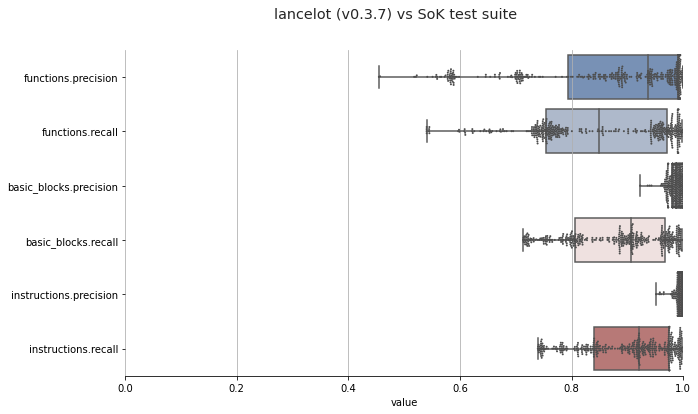

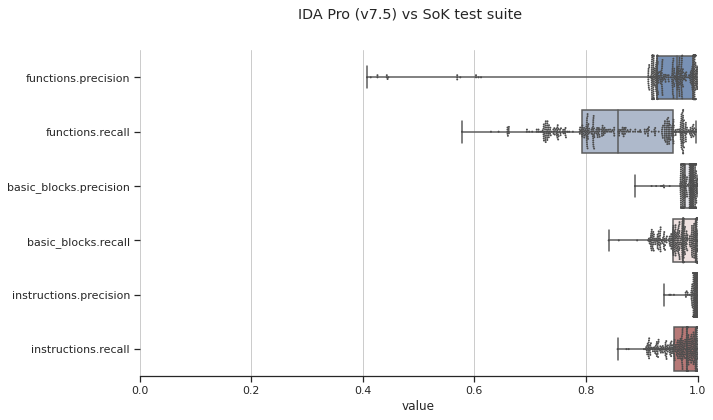

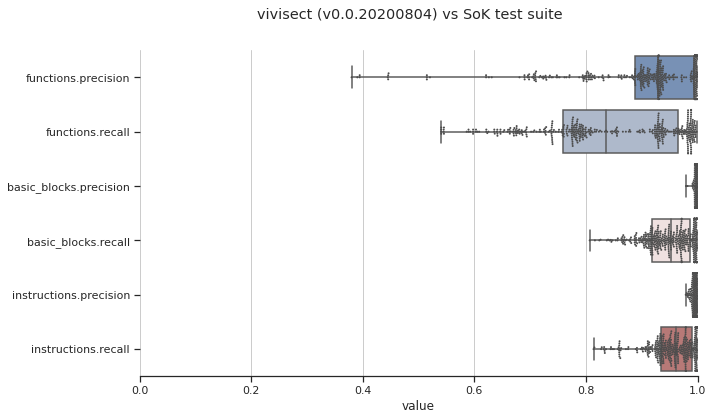

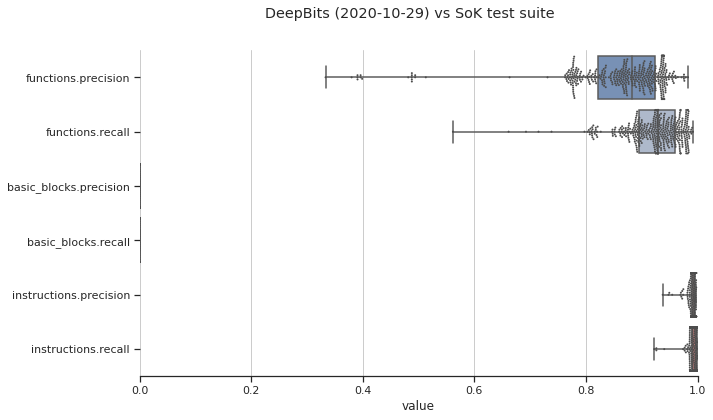

In [27]:
for fw, framework in frameworks.items():
    plot_pd(collect_pandas(results[fw]), title=f"{framework} vs SoK test suite")

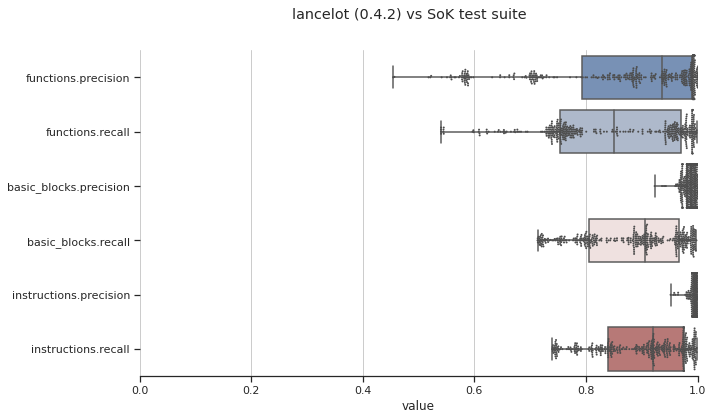

In [15]:
for fw, framework in frameworks.items():
    if "lancelot" not in fw: continue
    plot_pd(collect_pandas(results[fw]), title=f"lancelot (0.4.2) vs SoK test suite")

In [25]:
import tabulate

rows = []
for test in results["lancelot"].keys():
    frecall = results["lancelot"][test]["functions"]["recall"]
    rows.append((frecall, test))

rows = sorted(rows)

print(tabulate.tabulate(rows))

--------  --------------------------------------------------
0.319658  SoK-windows-testsuite/cl_O2/tee
0.319658  SoK-windows-testsuite/cl_Ox/tee
0.320613  SoK-windows-testsuite/cl_O1/tee
0.32097   SoK-windows-testsuite/cl_Od/tee
0.322366  SoK-windows-testsuite/cl_O2/xxd
0.322366  SoK-windows-testsuite/cl_Ox/xxd
0.322727  SoK-windows-testsuite/cl_O1/xxd
0.323776  SoK-windows-testsuite/cl_Od/xxd
0.368915  SoK-windows-testsuite/cl_O2/pageant
0.370444  SoK-windows-testsuite/cl_Ox/pageant
0.373436  SoK-windows-testsuite/cl_O1/pageant
0.374484  SoK-windows-testsuite/cl_O2/puttygen
0.376033  SoK-windows-testsuite/cl_Ox/puttygen
0.382467  SoK-windows-testsuite/cl_O1/puttygen
0.392491  SoK-windows-testsuite/cl_Od/pageant
0.403837  SoK-windows-testsuite/cl_Od/puttygen
0.408605  SoK-windows-testsuite/cl_O2/puttytel
0.409165  SoK-windows-testsuite/cl_Ox/puttytel
0.414866  SoK-windows-testsuite/cl_O1/puttytel
0.430197  SoK-windows-testsuite/cl_Od/puttytel
0.430242  SoK-windows-testsuite/cl_O2/psftp